<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

The goal is to compare `RNN` and `LSTM` on `Reuters News Wire` data.



## Import packages 


In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,RNN, LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.datasets import reuters

In [2]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2,\
"This notebook requires TensorFlow 2.0 or above"

TensorFlow version:  2.1.0


### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.1.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.2.4-tf


## Step 1: Loading Reuters dataset

We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. This is a dataset of 11,228 newswires from Reuters, labeled over 46 topics. Some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like MNIST and Fashion MNIST, the Reuters dataset comes packaged as part of Keras.

"Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data

In [5]:
(data, labels), (_, _) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=None, skip_top=0, maxlen=None, test_split=0,
                                      seed=113, start_char=1, oov_char=2, index_from=3)

## Step 2: EDA Reuters Dataset

In [6]:
print(f"There are {len(data)} Reuters News Articles with {len(labels)} labels.") 
print(f"There are {len(set(labels))} different label categories.")

There are 11228 Reuters News Articles with 11228 labels.
There are 46 different label categories.


In [7]:
print(f"The first five labels: {labels[:10]}")

The first five labels: [ 3  4  3  4  4  4  4  3  3 16]


## Mapping of classes to indices 
keeps track of our mapping of label values to the label indices, where the indices are actually predicted by our model. The label_map can map the label class back to the label name.

In [8]:
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

### Report the total number of documents, classes, and frequency distribution

we reversed the `class_to_idx` dictionary above so that we can decode the labels into classes

In [9]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} 

{6: 'copper',
 28: 'livestock',
 25: 'gold',
 19: 'money-fx',
 30: 'ipi',
 11: 'trade',
 0: 'cocoa',
 31: 'iron-steel',
 12: 'reserves',
 26: 'tin',
 37: 'zinc',
 34: 'jobs',
 13: 'ship',
 14: 'cotton',
 23: 'alum'}

In [10]:
classes = [idx_to_class[label] for label in labels]

In [11]:
Counter(classes).most_common()

[('earn', 3972),
 ('acq', 2423),
 ('money-fx', 682),
 ('crude', 543),
 ('grain', 537),
 ('trade', 473),
 ('interest', 339),
 ('ship', 209),
 ('money-supply', 177),
 ('sugar', 154),
 ('gnp', 127),
 ('coffee', 126),
 ('gold', 123),
 ('veg-oil', 94),
 ('cpi', 86),
 ('oilseed', 81),
 ('cocoa', 67),
 ('copper', 62),
 ('reserves', 62),
 ('bop', 60),
 ('livestock', 58),
 ('ipi', 57),
 ('jobs', 57),
 ('alum', 53),
 ('iron-steel', 52),
 ('nat-gas', 51),
 ('dlr', 46),
 ('rubber', 42),
 ('gas', 38),
 ('tin', 32),
 ('carcass', 29),
 ('pet-chem', 29),
 ('cotton', 28),
 ('wpi', 27),
 ('retail', 23),
 ('orange', 22),
 ('meal-feed', 22),
 ('wheat', 22),
 ('zinc', 21),
 ('housing', 19),
 ('lead', 19),
 ('strategic-metal', 19),
 ('hog', 17),
 ('lei', 16),
 ('silver', 16),
 ('heat', 16)]

### Preview Rueters News Articles 

Each document is a list of integers (word indexes).  We get the `word_index` dictionary and then reverse is to get the original text of the newswires

In [12]:
print(data[1])

[1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]


###  Decode 5 newswire articles 
We use the `reverse_word_index` dictionary to decode the 5 newswires (with different topic labels) and display them with along with their class labels.

tf.keras.datasets.reuters.get_word_index()
Retrieves a dict mapping words to their index in the Reuters dataset.

In [13]:
word_index = tf.keras.datasets.reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [14]:
selection = [classes.index(cls) for cls in set(classes)] # get one index per class
for k in [10,20,30,35,45]:   # picked from different 5 topics (using trial and error to find)
    # Note that our indices were offset by 3
    # because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
    decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in data[k]])
    print(f"Reuters News Article {k+1}:\n{decoded_newswire}","\n")
    print(f"Topic: {idx_to_class[labels[k]]}\n")

Reuters News Article 11:
? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3 

Topic: earn

Reuters News Article 21:
? leading u s farm state senators are seeking to insert into the senate's omnibus trade bill a provision that would broaden eligibility requirements under the u s agriculture department's export enhancement program eep to include traditional buyers of u s farm products including the soviet union senate staff said under existing criteria usda can offer eep subsidies to recoup export markets lost to competing nations' unfair trading practices senate agriculture committee chairman patrick leahy d vt is leading a group of farm state senators in an effort to broaden the criteria in such a way as to enable moscow to be eligible for the subsidies sources said the senators including senate finance committee chairman lloyd bentsen d tex max baucus d mont david pryor d ark john melcher d mont and thad 

### Examine words in the corpus (Unique / Most Frequent / Least Frequent)
To get the data corpus we first get the list of indexes<br>
NOTE: "start of sequence" will appear as "?"

In [15]:
indexes = [word for doc in data for word in doc]  
print(f"There are {len(indexes)} words in the data corpus")

There are 1638886 words in the data corpus


### Top 25 most common words in the corpus

In [16]:
corpus = [reverse_word_index.get(index,'?') for index in indexes]
corpus_freq = Counter(corpus).most_common()
corpus_freq[:25]

[('in', 82723),
 ('said', 42393),
 ('and', 40350),
 ('a', 33157),
 ('mln', 29978),
 ('3', 29956),
 ('for', 29581),
 ('vs', 20141),
 ('dlrs', 16668),
 ('it', 15224),
 ('reuter', 15015),
 ('000', 13329),
 ('1', 12395),
 ('the', 11228),
 ('pct', 11191),
 ('on', 11039),
 ('from', 10755),
 ('is', 10746),
 ('that', 10377),
 ('its', 9345),
 ('cts', 9113),
 ('by', 9022),
 ('at', 8579),
 ('year', 8451),
 ('be', 8311)]

### Top 25 least common words in the corpus

In [17]:
uniques = [word for word,freq in Counter(corpus).items() if freq == 1]
print(f"There are {len(uniques)} words that occur just once in the data corpus totaling 1638886 words")

There are 10305 words that occur just once in the data corpus totaling 1638886 words


In [18]:
corpus_freq[:-26:-1]

[('barrelling', 1),
 ('bionomic', 1),
 ('atcma', 1),
 ('leopoldo', 1),
 ('departnment', 1),
 ('greylock', 1),
 ('knives', 1),
 ('theys', 1),
 ('gienow', 1),
 ('tentonian', 1),
 ('trifles', 1),
 ('brutal', 1),
 ('mustapha', 1),
 ('ufe', 1),
 ('armatron', 1),
 ('outraged', 1),
 ('enliven', 1),
 ('7801', 1),
 ('billard', 1),
 ('sulphurisation', 1),
 ('ncw', 1),
 ('collapsing', 1),
 ('rechannelling', 1),
 ('schipol', 1),
 ('monopolising', 1)]

### Number of words corpus vocabulary

In [19]:
unique_indexes = list(set(indexes))
print(f"There are {len(unique_indexes)} words in the data corpus that represent the vocabulary")

There are 30980 words in the data corpus that represent the vocabulary


In [20]:
uniques[:25]

['wattie',
 'nondiscriminatory',
 "recommend's",
 'supplie',
 'linares',
 'unsubsidised',
 'optioon',
 'nonbelligerent',
 '8231',
 "regime's",
 'effot',
 'kuomintang',
 'silently',
 'disapproval',
 'monarch',
 'erba',
 'hoax',
 'cnpc',
 'elbe',
 'bavaria',
 'mutton',
 'saffron',
 'thunderstorms',
 'rogaland',
 'atkinson']

###  Overview of word corpus <br>

| Word Frequency  | Description    |  Count        |  Percentage   |
| :---            |    :----:      |     :----:    |          ---: |
| Top 25 Words    | High Frequency |     499,067   |       0.30451 |
| Bottom 25 Words | Low Frequency  |      10,305   |       0.00628 |
| Unique Words    | Unique         |      30,398   |       0.01890 |


In [21]:
vocabulary_df = pd.DataFrame(Counter(Counter(corpus).values()).most_common(),columns=['freq', 'num of words'])
vocabulary_df.sort_values(by='freq',).head(10)

,freq,num of words
0,1,10305
1,2,4412
2,3,2465
3,4,1707
4,5,1093
5,6,930
6,7,685
7,8,578
8,9,451
9,10,380


### Review documents and create a histogram based on the number of words contain within each document

In [22]:
doc_sizes = ([len(lst) for lst in data]) # num of words in each document
print(f"Number of words in Rueters News Articles: {min(doc_sizes)} to {max(doc_sizes)}")
print(f"There are a total of {sum(doc_sizes)} words in the data corpus")

Number of words in Rueters News Articles: 2 to 2376
There are a total of 1638886 words in the data corpus


### Review distribution of the document sizes for data corpus

Text(0, 0.5, 'Number of Reuters News Articles')

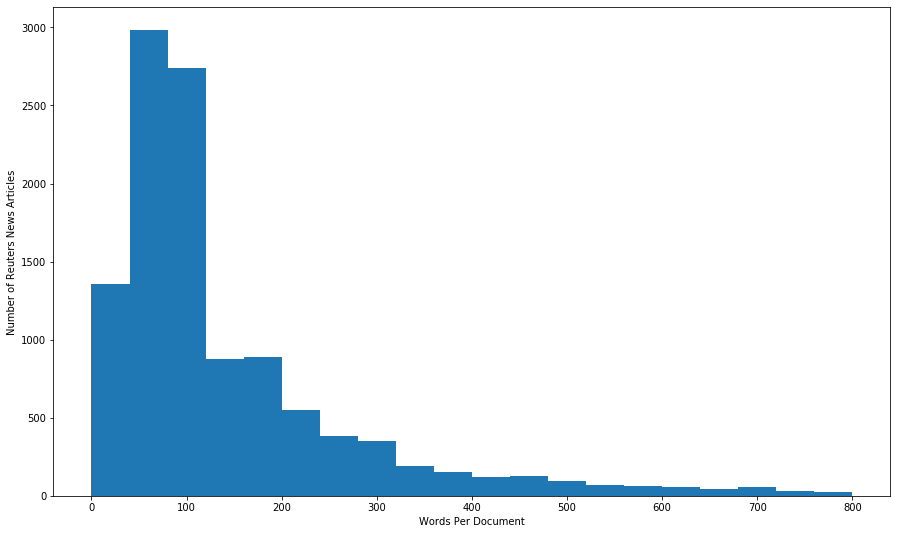

In [23]:
plt.figure(figsize=[15,9])
plt.hist(doc_sizes, bins=20,range = (0,800))
plt.xlabel("Words Per Document")
plt.ylabel("Number of Reuters News Articles")

Distribution is right screwed, most of the words contained with the first couple hundred documents

## Step 3: Preprocess Reuters Dataset

Decisions resulting from EDA<br>
Input Vector size from document length (maxlen)<br>
Skip Top 25 words - as non-informative (skip_top)

In [24]:
voc_size=10500

In [25]:
(train_data, train_labels),(test_data, test_labels) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=voc_size, skip_top=26, maxlen=300, test_split=0.2,
                                      seed=113, start_char=1, oov_char=2, index_from=26)

### Review Data (Training / Test)

In [26]:
train_labels.shape, test_labels.shape

((7976,), (1994,))

### Review training and testing split of words 

In [27]:
train_data_sizes = [len(s) for s in train_data]
test_data_sizes = [len(s) for s in test_data]

In [28]:
f"There are {sum(train_data_sizes)} words in the training data corpus"

'There are 827922 words in the training data corpus'

In [29]:
f"There are {sum(test_data_sizes)} words in the test data corpus"

'There are 206813 words in the test data corpus'

### Padding Input Vector (Sequences) 

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.<br>

Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.<br>

Sequences longer than num_timesteps are truncated so that they fit the desired length.<br>

The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.<br>

In [30]:
train_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(train_data, padding='post')
test_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(test_data, padding='post')

In [31]:
train_data_rnn.shape, test_data_rnn.shape

((7976, 299), (1994, 299))

### One Hot Encoding Labels

We will change the way this label is represented from a class name or number, to a vector of all possible classes with all the classes set to 0 except the one which this example belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 3 | [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] |
| 4 | [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] |
| 5 | [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] |

In [32]:
train_labels_encoded = to_categorical(train_labels)
test_labels_encoded = to_categorical(test_labels)

print("First ten entries of train_labels:\n {}\n".format(train_labels[0:5]))
print("First ten rows of one-hot train_labels:\n {}".format(train_labels_encoded[0:5,]))

First ten entries of train_labels:
 [3 4 3 4 4]

First ten rows of one-hot train_labels:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Step 4 Build SimpleRNN Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/SimpleRNNArchitecture.png?raw=1">

In [33]:
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=299))
model.add(SimpleRNN(units=256,activation='tanh',use_bias=True))
model.add(Dense(units=46, activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 299, 128)          1344000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               98560     
_________________________________________________________________
dense (Dense)                (None, 46)                11822     
Total params: 1,454,382
Trainable params: 1,454,382
Non-trainable params: 0
_________________________________________________________________


### Calculate the Number of Parameters Per Layer
Embedding Parameters = num_words(10500) * size of output (128)<br> 
RNN Parameters = [(size_of_input + 1) * size_of_output + size_of_output^2)]<br>
Dense Layer = size of input(256+1) * size of output(46) 

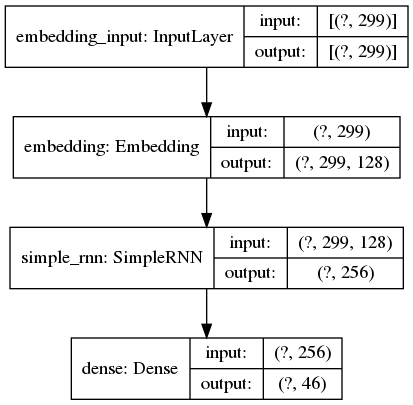

In [35]:
keras.utils.plot_model(model, "SimpleRNN_model.png", show_shapes=True) 

### Compile SimpleRNN Model

In [36]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Define Callback - Training Time Statistics

In [37]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

### Training SimpleRNN Model

In [38]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_rnn,
                    train_labels_encoded,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=128,
                    validation_split = 0.15)   

Train on 6779 samples, validate on 1197 samples
Epoch 1/10
6779/6779 [==============================] - 46s 7ms/sample - loss: 2.4552 - accuracy: 0.3260 - val_loss: 2.5646 - val_accuracy: 0.3734
Epoch 2/10
6779/6779 [==============================] - 42s 6ms/sample - loss: 2.3677 - accuracy: 0.3608 - val_loss: 2.3982 - val_accuracy: 0.3751
Epoch 3/10
6779/6779 [==============================] - 42s 6ms/sample - loss: 2.3583 - accuracy: 0.3638 - val_loss: 2.3565 - val_accuracy: 0.3751
Epoch 4/10
6779/6779 [==============================] - 42s 6ms/sample - loss: 2.3474 - accuracy: 0.3697 - val_loss: 2.3626 - val_accuracy: 0.3743
Epoch 5/10
6779/6779 [==============================] - 42s 6ms/sample - loss: 2.3614 - accuracy: 0.3682 - val_loss: 2.3457 - val_accuracy: 0.3751
Epoch 6/10
6779/6779 [==============================] - 42s 6ms/sample - loss: 2.3483 - accuracy: 0.3728 - val_loss: 2.3521 - val_accuracy: 0.3743
Epoch 7/10
6779/6779 [==============================] - 42s 6ms/sample

### Training Time Statistics SimpleRNN

In [39]:
train_time = (train_rt.process_time/60)
train_time

7.112741116666667

### Test SimpleRNN Model

In [40]:
loss, accuracy = model.evaluate(test_data_rnn, test_labels_encoded)
print('test set accuracy: ', accuracy * 100)

1994/1994 [==============================] - 6s 3ms/sample - loss: 2.3503 - accuracy: 0.3972
test set accuracy:  39.719158411026


### Plotting Performance Metrics SimpleRNN

In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

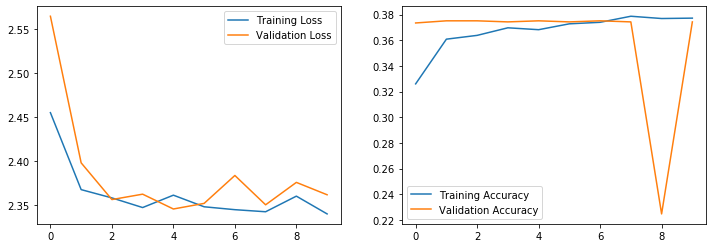

In [43]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Step 5 Build LSTM Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/LSTMcellArchitecture.png?raw=1">

In [44]:
(train_data, LSTMtrain_labels),(test_data, LSTMtest_labels) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=30980, skip_top=26, maxlen=2376, test_split=0.2,
                                      seed=113, start_char=1, oov_char=2, index_from=26)

In [45]:
LSTMtrain_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(train_data,maxlen=1032)
LSTMtest_data_rnn = tf.keras.preprocessing.sequence.pad_sequences(test_data,maxlen=1032)
LSTMtrain_encoded = to_categorical(LSTMtrain_labels)
LSTMtest_encoded = to_categorical(LSTMtest_labels)

In [46]:
LSTMtrain_data_rnn.shape, LSTMtest_data_rnn.shape

((8981, 1032), (2246, 1032))

In [47]:
LSTMmodel= Sequential()
LSTMmodel.add(Embedding(input_dim=30980, output_dim=256, input_length=1032))
LSTMmodel.add(LSTM(units = 256))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(units = 46, activation='softmax'))

In [48]:
LSTMmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1032, 256)         7930880   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                11822     
Total params: 8,468,014
Trainable params: 8,468,014
Non-trainable params: 0
_________________________________________________________________


### Calculate the Number of Parameters Per Layer
Embedding Parameters = num_words(30980) * size of output (256)<br> 
LSTM Parameters = 4 * [(size_of_input + 1) * size_of_output + size_of_output^2)]<br>
Dense Layer = size of input(256+1) * size of output(46) 

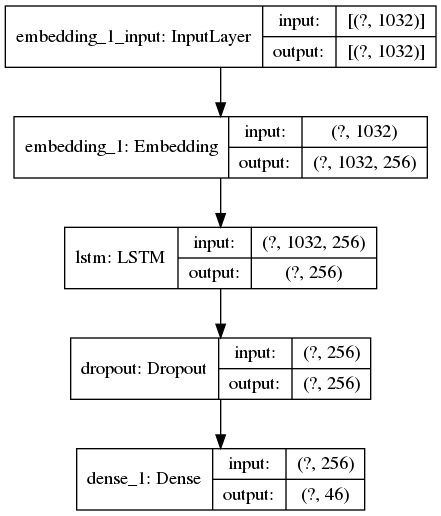

In [49]:
keras.utils.plot_model(LSTMmodel, "LSTM_model.png", show_shapes=True) 

### Compile LSTM Model

In [50]:
LSTMmodel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training LSTM Model

In [51]:
train_rt = TrainRuntimeCallback()
history = LSTMmodel.fit(LSTMtrain_data_rnn,
                    LSTMtrain_encoded,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=64,
                    validation_split = 0.15) 

Train on 7633 samples, validate on 1348 samples
Epoch 1/10
7633/7633 [==============================] - 992s 130ms/sample - loss: 2.3522 - accuracy: 0.3959 - val_loss: 1.9549 - val_accuracy: 0.5015
Epoch 2/10
7633/7633 [==============================] - 989s 130ms/sample - loss: 1.7819 - accuracy: 0.5370 - val_loss: 1.7036 - val_accuracy: 0.5616
Epoch 3/10
7633/7633 [==============================] - 985s 129ms/sample - loss: 1.5383 - accuracy: 0.6037 - val_loss: 1.5699 - val_accuracy: 0.5927
Epoch 4/10
7633/7633 [==============================] - 985s 129ms/sample - loss: 1.2868 - accuracy: 0.6726 - val_loss: 1.5639 - val_accuracy: 0.6350
Epoch 5/10
7633/7633 [==============================] - 985s 129ms/sample - loss: 1.1043 - accuracy: 0.7190 - val_loss: 1.3711 - val_accuracy: 0.6892
Epoch 6/10
7633/7633 [==============================] - 987s 129ms/sample - loss: 0.9971 - accuracy: 0.7508 - val_loss: 1.4015 - val_accuracy: 0.6543
Epoch 7/10
7633/7633 [==============================

### Training Time Statistics LSTM 

In [52]:
LSTMtrain_time = (train_rt.process_time/60)
LSTMtrain_time

164.41549533333333

### Test LSTM Model

In [53]:
loss, accuracy = LSTMmodel.evaluate(LSTMtest_data_rnn, LSTMtest_encoded)
print('test set accuracy: ', accuracy * 100)

2246/2246 [==============================] - 127s 57ms/sample - loss: 1.5591 - accuracy: 0.6647
test set accuracy:  66.47372841835022


### Plotting Performance Metrics LSTM

In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

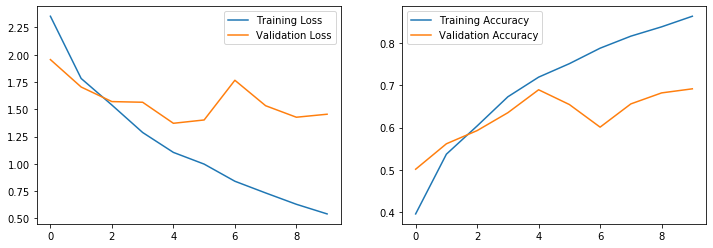

In [56]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()